In this lab, you will build pipeline for a language generation model.

You will read text data from file, process it (make Vocabulary and tokanize).
Then you will build your RNN model using various varients of RNN cells.
Train and Evaluate the model and finally generate random text.

In [ ]:
import os
import time
import math
import torch
import torch.nn as nn

from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
from io import open

class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary (make Vocabulary)
        with open(path, 'r', encoding="utf8") as f:
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    self.dictionary.add_word(word)


        # Tokenize file content
        with open(path, 'r', encoding="utf8") as f:
            idss = []
            for line in f:
                words = line.split() + ['<eos>']
                ids = []
                for word in words:
                    ids.append(self.dictionary.word2idx[word])
                idss.append(torch.tensor(ids).type(torch.int64))
            ids = torch.cat(idss)   # Concatinate all idss
            #print(ids)
            #ip=input("Next")
        return ids
#corpus = Corpus('/content/gdrive/My Drive/RNN-Lab/data/wikitext-2')

In [ ]:
import torch.nn.functional as F

class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.ntoken = ntoken
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            try:
                nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            except KeyError:
                raise ValueError( """An invalid option for `--model` was supplied,
                                 options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']""")
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()
        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        ### Write code for Initialising Weights ###
          # You may initialise weights of encoder and decoder from uniform distribution
          # You may initialise biases for decoder with zeros.
        ### Start Code (about 3 lines)
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)
        ### End Code

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))
        else:
            return weight.new_zeros(self.nlayers, bsz, self.nhid)

    def forward(self, input, hidden): # Accepts and hidden state a(i)
        ### Implement forward pass ###

        # From encoder, get an embedding x(i) and apply dropout on it.
        # Pass the embedding and hidden to rnn model
        # apply dropout on output (optional)
        # pass this output to decoder and get decoded output
        ### Start your code (4 Lines)
        embed = self.drop(self.encoder(input))
        output, hidden = self.rnn(embed, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.ntoken)
        ### End your code    
        return F.log_softmax(decoded, dim=1), hidden

tensorA.view(a,b) rehsapes the tensorA to a rown and b columns. However, if we don't know exactly how many rows will be there when we reshape the data (but we do know how many columns we want), we can use -1 as the argument for number of rows. The same can be done with unknown number of columns (rows are known). We cannot use -1 on both locations.

Try initialising encoder biases. What happens?

What is the reason for this?

Answer: encoder is an object to type nn.Embedding (look in the code above). Embedding simply makes a look up table that stores embeddings of a fixed dictionary and size. This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.
Decoder is an object of nn.Linear, which implements a hidden layer.

In [ ]:
# Configure your Model

from torch.nn.modules.module import T

data = '/content/drive/MyDrive/Lab4/wikitext-2'
print(data)

model = 'RNN_TANH' # @ RNN_TANH, RNN_RELU, LSTM, GRU, Transformer

emsize = 256        # Size of Embeddings (the word vectors)
nhid = 128          # Number of hidden units per layer
nlayers = 1         # Number of hidden layers
lr = 20             # Initial Learning Rate
clip = 0.25         # Gradient Clipping, used for addressing exploding gradients.
epochs = 4        # Maximum number of epochs
batch_size = 20     # 
#metavar = 'N'
bptt = 35           # Sequence Length
dropout = 0.2       # Dropout probability
#tied = False        # Tie the word embeddings and softmax weights
seed = 42           # random seed
cuda = False        # If CUDA is availble, use it.
#mps = True          # enables macOS GPU training
log_interval = 200  # How often log should be reported
save = '/content/drive/MyDrive/Lab4/model.pt'     # path to save the model
#onnx_export = ''    # path to export the final model in onnx format
#nhead = 2           # 'the number of heads in the encoder/decoder of the transformer model'
dry_run = True      # verify the code and the model

# Set the random seed manually for reproducibility.
torch.manual_seed(seed)

if torch.cuda.is_available():
    if not cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda.")
if cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load Data
corpus = Corpus(data)

/content/drive/MyDrive/Lab4/wikitext-2


In [ ]:
# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

def batchify(data, bsz): # bsz is batch-size
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

eval_batch_size = 10
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

###############################################################################
# Build the model
###############################################################################

ntokens = len(corpus.dictionary)
model = RNNModel(model, ntokens, emsize, nhid, nlayers, dropout).to(device)
criterion = nn.NLLLoss()

###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

# get_batch subdivides the source data into chunks of length bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘

# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

def train():
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(batch_size)
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        model.zero_grad()
        hidden = repackage_hidden(hidden)

        ### Impement Training Pass
          # pass the data and hidden state to the model
          # calculate loss
          # backpropogate loss
        
        ### Start your code (3 lines)
        output, hidden = model(data, hidden)
        loss = criterion(output, targets)
        loss.backward()
        ### End your code

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        for p in model.parameters():
            p.data.add_(p.grad, alpha=-lr)

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // bptt, lr,
                elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
        if dry_run:
            break

def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    
    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            hidden = repackage_hidden(hidden)
            total_loss += len(data) * criterion(output, targets).item()
    return total_loss / (len(data_source) - 1)



# Loop over epochs.
lr = lr
best_val_loss = None

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, epochs+5):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(save, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 4.0
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

# Load the best saved model.
with open(save, 'rb') as f:
    model = torch.load(f)
    # after load function, the rnn params are not a continuous chunk of memory
    # The following line of code makes them a continuous chunk, and will speed up forward pass
    # Currently, only rnn model supports flatten_parameters function.
    if model in ['RNN_TANH', 'RNN_RELU', 'LSTM', 'GRU']:
        model.rnn.flatten_parameters()

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 88.55s | valid loss 10.25 | valid ppl 28209.43
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 87.15s | valid loss 10.55 | valid ppl 38003.78
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 87.64s | valid loss  9.03 | valid ppl  8381.77
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 86.67s | valid loss  8.55 | valid ppl  5146.61
--------------------------------------------------------------------------

In [ ]:
###############################################################################
# Language Modeling on Wikitext-2
#
# This Code generates new sentences sampled from the language model.
#
###############################################################################

checkpoint =      '/content/drive/MyDrive/Lab4/model.pt'         # Model Checkpoints
outfile =         '/content/drive/MyDrive/Lab4/generated.txt'    # Output file for generated text
words = 1000                                                          # How many words to generate
temperature = 1.0                                                     # Higher temperature will increase diversity among words

if temperature < 1e-3:
    print("--temperature has to be greater or equal 1e-3.")

with open(checkpoint, 'rb') as f:
    model = torch.load(f, map_location=device)
model.eval()

corpus = Corpus(data)
ntokens = len(corpus.dictionary)

hidden = model.init_hidden(1)                                   # initialize a[0] randomly
input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)

with open(outfile, 'w') as outfile:
    with torch.no_grad():  # no tracking history
        for i in range(words):
            output, hidden = model(input, hidden)                         # Initial input to the sequence generation model is a random number, a[0] is also random.
            word_weights = output.squeeze().div(temperature).exp().cpu()  # Softmax probabilities of each word in the corpus.
            word_idx = torch.multinomial(word_weights, 1)[0]              # Index of the word (from the corpus) belonging to the highest probability.
            input.fill_(word_idx)

            word = corpus.dictionary.idx2word[word_idx]

            outfile.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % log_interval == 0 and i != 0:
                print('| Generated {}/{} words'.format(i, words))

    print('\nOutput generated')

| Generated 200/1000 words
| Generated 400/1000 words
| Generated 600/1000 words
| Generated 800/1000 words

Output generated


Read the generated text file. Does the text make any sense?

Screenshot of generated text file:
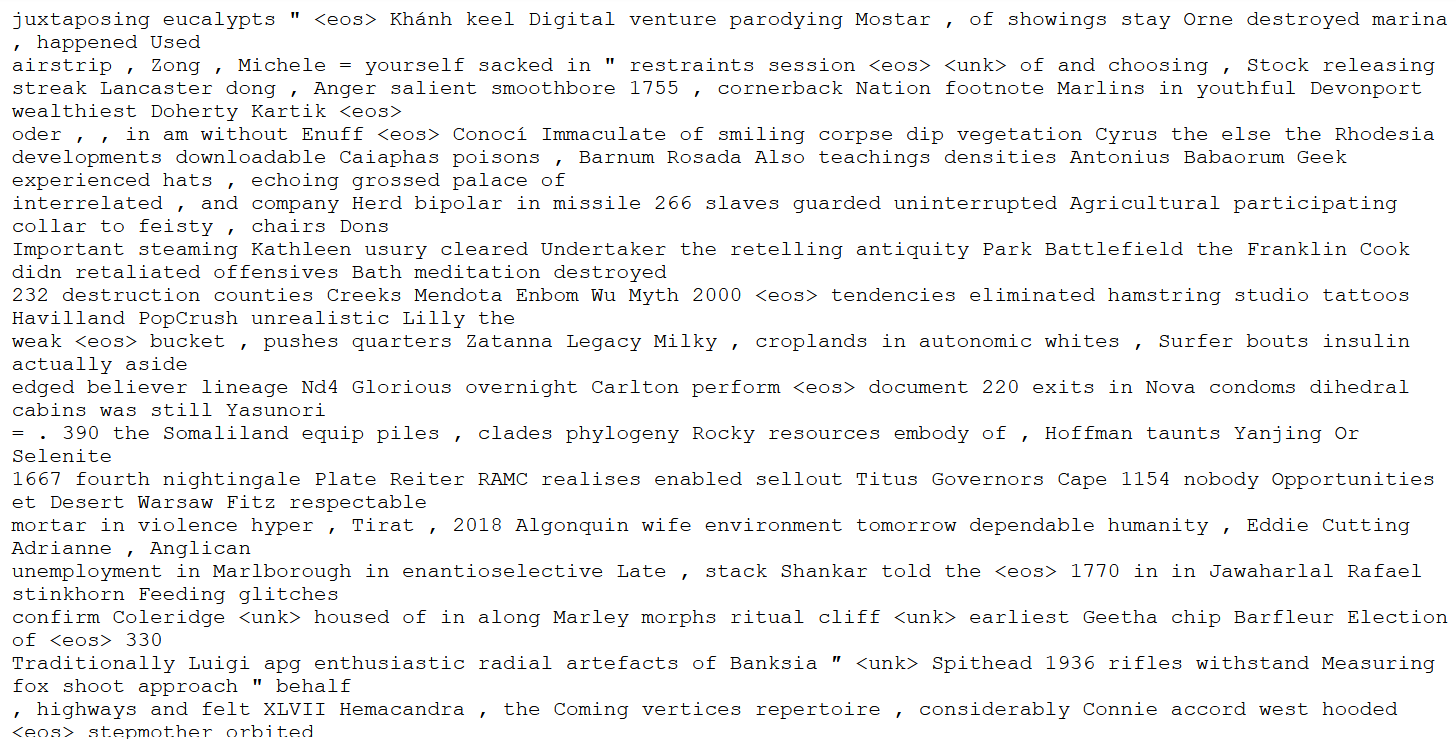


How can you improve the coherence of the generated text (just write in few sentences)?

The coherence can be improved by using pre-trained word embeddings. A word embedding is a vector representation with each componenet as a feature of the word. This helps the network learn the context, and similarity between words thus improving the coherence.

